In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport deepsvr

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from analysis_utils.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot
from analysis_utils.Analysis import print_accuracy_and_classification_report, predict_classes, get_somatic_error_type

sns.set_style("white")
sns.set_context('poster')

C:\Users\shubh\Documents\applied machine learning\DeepSVR\analysis_utils\Analysis.py:101: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if feature is not 'disease':


In [4]:
# Pull in training data
training_data = pd.read_pickle('data/training_data_preprocessed.pkl')
training_data.sort_index(axis=1, inplace=True)

In [5]:
# Remove AML31 case
aml31_training = training_data[training_data.index.str.contains('fSsMNn1DZ3AIDGk=')]
training_data = training_data[~training_data.index.str.contains('fSsMNn1DZ3AIDGk=')]

In [6]:
# Show the calls associate with training data
training_data.groupby('call').size()

call
a    10643
f     8854
g     3122
s    18381
dtype: int64

In [7]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Somatic, ambigous, fail classifier

In [8]:
# Re-label the germline calls as failed calls
three_class = training_data.replace('g','f')
three_class.sort_index(axis=1, inplace=True)

In [9]:
# Show the calls associate with training data
three_class.groupby('call').size()

call
a    10643
f    11976
s    18381
dtype: int64

In [10]:
# Get labels for training data
Y = three_class.call.values
# Get training data as numpy array
X = training_data.drop(['call'], axis=1).astype(float).values

In [11]:
# Split the data for cross-validation
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=seed)

In [12]:
# Determine shape of training data features for cross-validation
X_train.shape

(27470, 71)

In [13]:
# Determine shape of training data calls for cross-validation
Y_train.shape

(27470,)

In [14]:
# Set parameters for the Random Forest Model
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
enc = preprocessing.MultiLabelBinarizer()
Y_one_hot = enc.fit_transform(Y_train)

In [ ]:
# Perform cross validation and pull AUC for various splits
auc = []
for n in [100, 1000, 10000]:
    est = RandomForestClassifier(n_estimators=n, max_features=8,n_jobs=-1, 
                                 oob_score=True)
    probs = cross_val_predict(est, X_train, Y_train, cv=kfold, method='predict_proba')
    temp_auc = []
    for j in range(Y_one_hot.shape[1]):
        temp_auc.append(metrics.roc_auc_score(Y_one_hot[:, j], probs[:, j]))
    auc.append(temp_auc)
    print('Test AUC for {0} trees: '.format(n), temp_auc)
    print('---------------------------------------------------------')

Test AUC for 100 trees:  [0.9603019981281358, 0.9900937444937876, 0.9795983172792626]
---------------------------------------------------------
Test AUC for 1000 trees:  [0.9615880191145809, 0.9904762417806628, 0.9801466322485098]
---------------------------------------------------------


In [16]:
# Set parameters for the extimator
estimator = RandomForestClassifier(n_estimators=1000, max_features=8, 
                                   n_jobs=-1, oob_score=True)

In [17]:
# Perform cross validation
probabilities = cross_val_predict(estimator, X_train, Y_train, cv=kfold, method='predict_proba')

In [18]:
# Save the probabilities in /data folder
np.save('data/random_forest/1000estimators.npy', probabilities)

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [19]:
# print accuracy report
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

Cross validation accuracy:
	 0.8933745904623225

Cross validation classification report

              precision    recall  f1-score   support

           0       0.85      0.78      0.82      7189
           1       0.92      0.92      0.92      8015
           2       0.90      0.94      0.92     12266

   micro avg       0.89      0.89      0.89     27470
   macro avg       0.89      0.88      0.88     27470
weighted avg       0.89      0.89      0.89     27470
 samples avg       0.89      0.89      0.89     27470



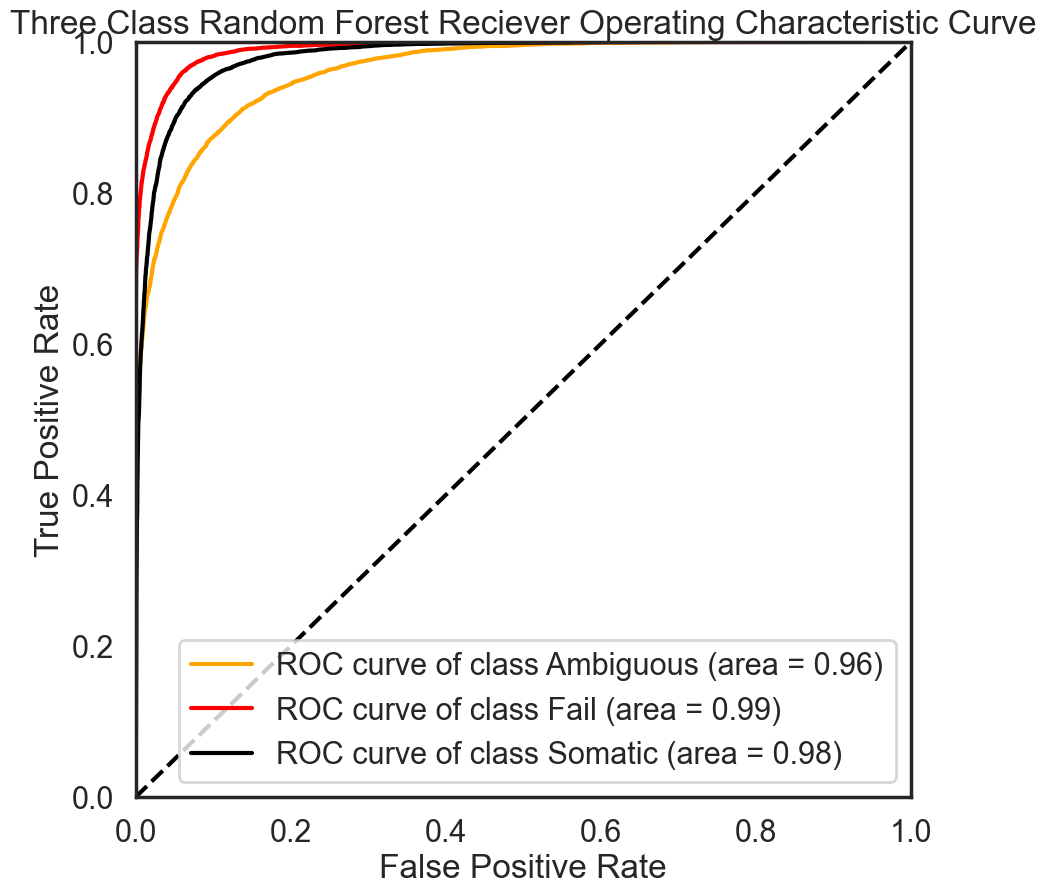

In [20]:
# Plot ROC for Random Forest Model
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots(figsize=(10,10),dpi=100)
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Three Class Random'
                 ' Forest Reciever Operating Characteristic Curve', ax)

confidence intervals +-:  [0.00059112 0.00330825 0.00588456 0.00820401 0.00936864 0.00995637
 0.00908074 0.00674379 0.0042155  0.0006948 ]


C:\Users\shubh\Documents\applied machine learning\DeepSVR\analysis_utils\ClassifierPlots.py:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([0, 1], [0, 1], 'k--', color='grey', linewidth=1)


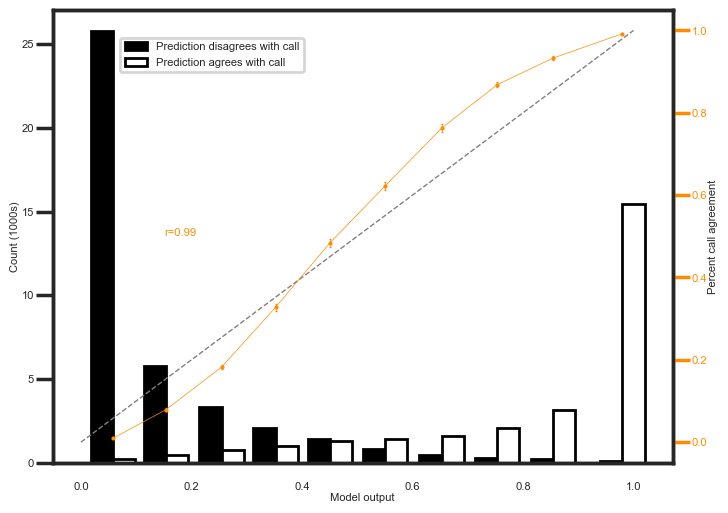

In [21]:
# Plot reliability diagram for Random Forest Model
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y_one_hot,['Ambiguous','Fail','Somatic'], 'darkorange', '',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

## Feature importance analysis

In [22]:
# Rebuild random forest model
forest = estimator.fit(X_train, Y_train)

In [23]:
# Sum the feature importance metrics for one-hot encoded variables
# (Feature importance calculation in scikit-learn is outlined 
# here https://stackoverflow.com/a/15821880/3862525).
# Since the importances are calculated with the same denominator, summing is
# appropriate
def sum_features(feature_import, label):
    starts_with_label = feature_import.feature.str.startswith(label)
    return feature_import.importance[starts_with_label].sum()

In [24]:
#Global Var
RF_Imp_features = []
# Create function to determine the feature importance 
def create_feature_importance_plot(trained_model, save_fp='random_forest_feature_import.pkl'):
    feature_import = pd.DataFrame([training_data.drop(['call'], axis=1).columns.values,trained_model.feature_importances_]).T
    feature_import.columns = ['feature', 'importance']
    summed_importances = []
    for label in ['disease', 'reviewer']:
        summed_importances.append([label, sum_features(feature_import, label)])
    summed_importances = pd.DataFrame(summed_importances, columns=['feature','importance'])
    feature_import.to_pickle(save_fp)
    feature_import.sort_values('importance', ascending=False, inplace=True)
    feature_import.replace({'feature':{'var':'variant','ref':'reference', 'avg':'average', '_se_':'_single_end_', '3p':'3_prime', '_':' '}}, regex=True, inplace=True)
    plt.figure(figsize=(15, 15))

    sns.barplot(y='feature', x='importance', data=feature_import.head(30), color='darkorange')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.title('Random forest feature importance')
    global RF_Imp_features
    RF_Imp_features = feature_import


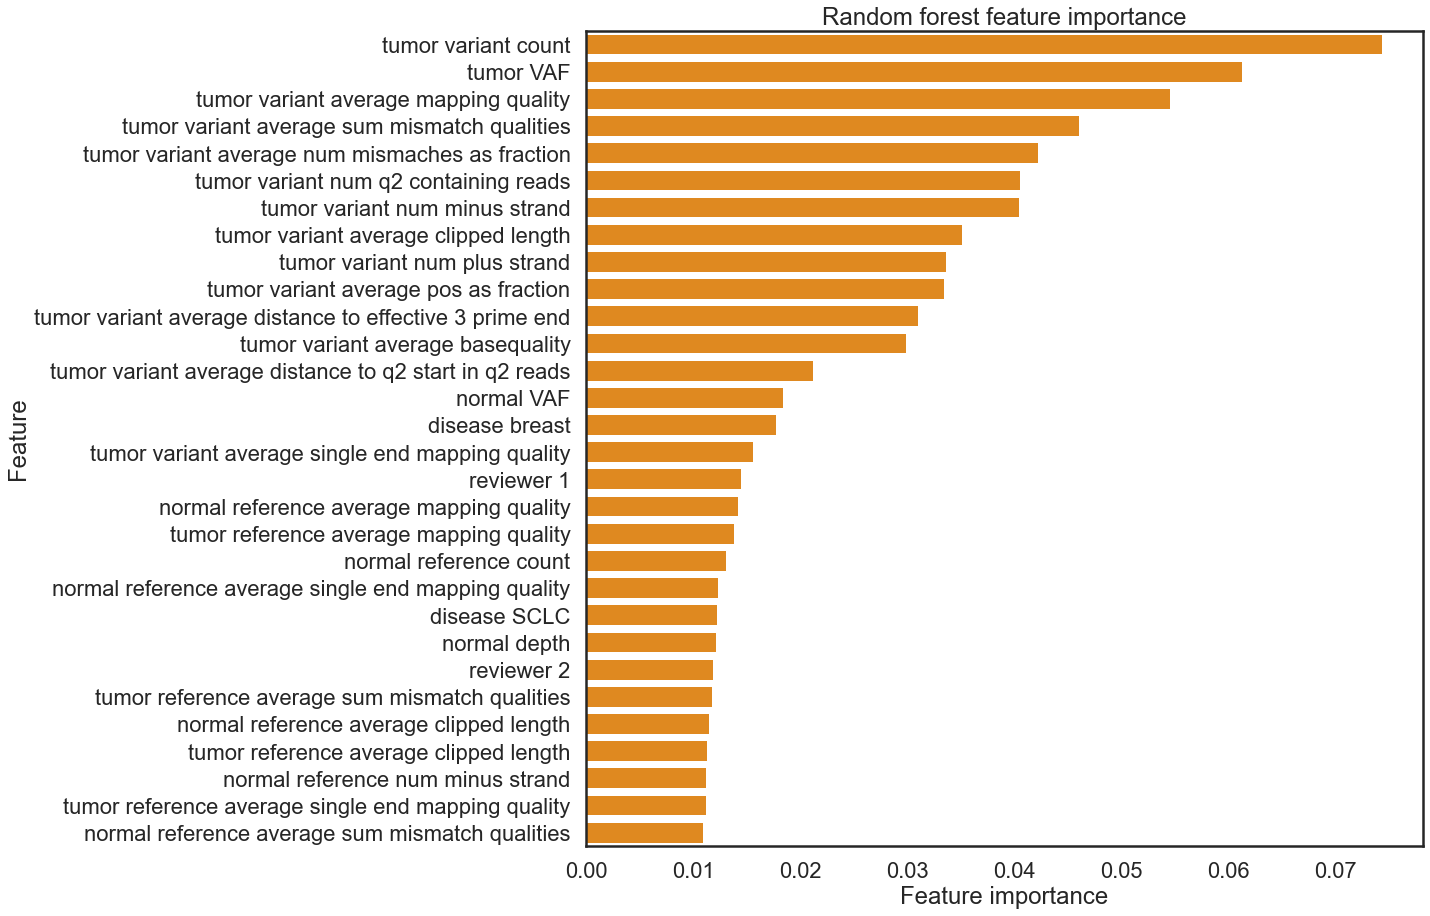

In [25]:
# Plot feature importance graph
create_feature_importance_plot(forest)

In [26]:
RF_Imp_features

,feature,importance
67,tumor variant count,0.074482
42,tumor VAF,0.061398
62,tumor variant average mapping quality,0.054612
66,tumor variant average sum mismatch qualities,0.046155
63,tumor variant average num mismaches as fraction,0.042308
...,...,...
40,reviewer 3,0.000664
8,disease melanoma,0.000578
41,reviewer 4,0.000184
1,disease GST,0.00016


### Test set performance

In [27]:
# Determine performance on test set
test_prob = forest.predict_proba(X_test)

In [28]:
# Transform labels for predictions
Y_test_labels = enc.fit_transform(Y_test)

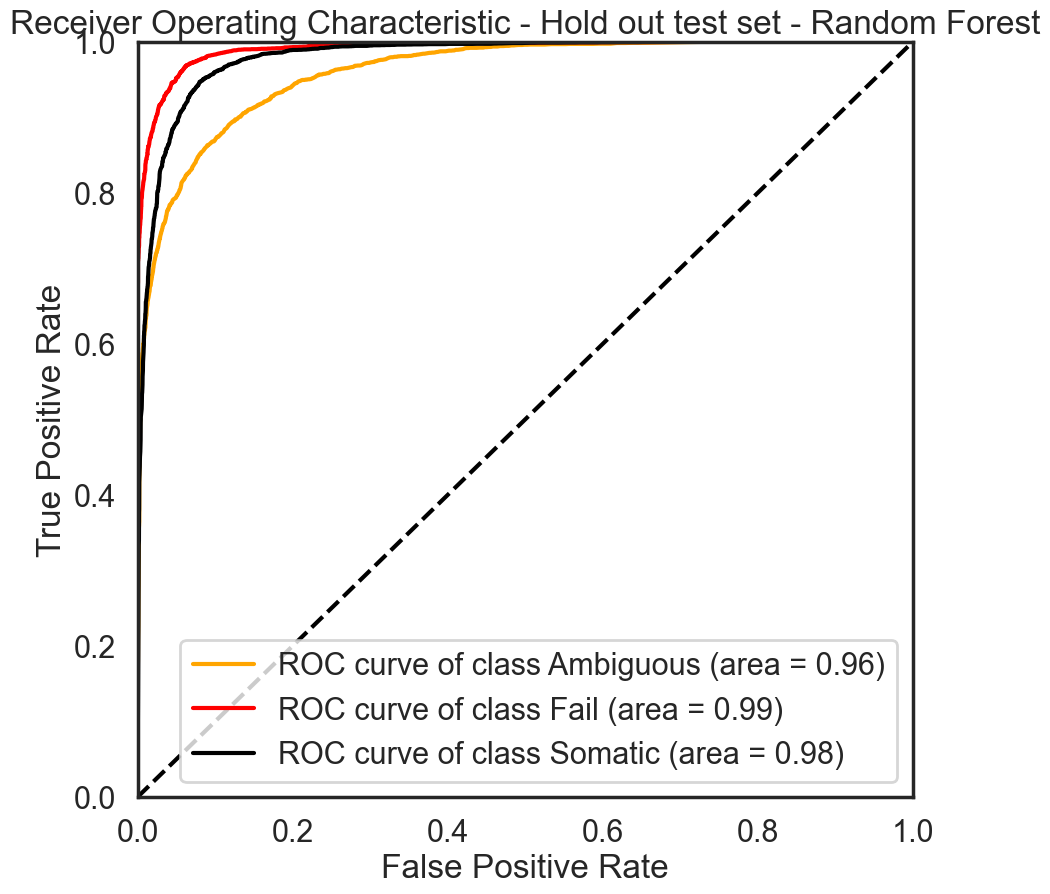

In [29]:
# Plot AUC for test set
fig, ax = plt.subplots(figsize=(10,10),dpi=100)
create_roc_curve(Y_test_labels, test_prob, class_lookup, 'Receiver Operating '
                 'Characteristic - Hold out test set - '
                 'Random Forest', ax)

confidence intervals +-:  [0.00087175 0.00439265 0.00846311 0.01168525 0.01366981 0.01421243
 0.01275185 0.00907834 0.00570986 0.00110192]


C:\Users\shubh\Documents\applied machine learning\DeepSVR\analysis_utils\ClassifierPlots.py:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([0, 1], [0, 1], 'k--', color='grey', linewidth=1)


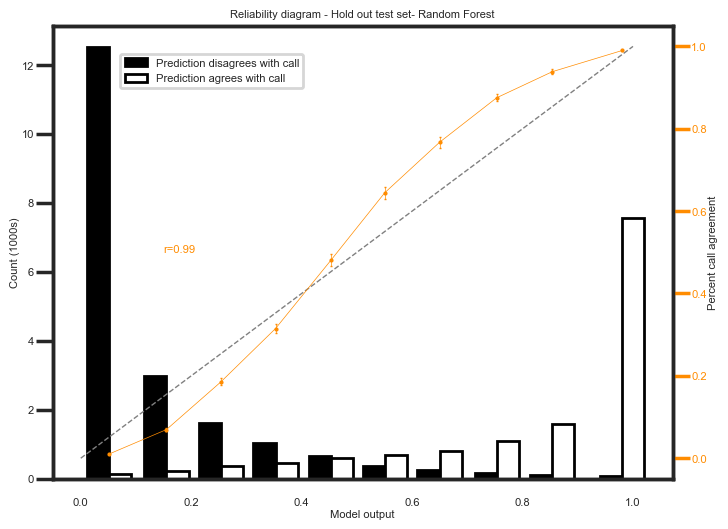

In [30]:
# Plot reliability diagram for test set
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(test_prob, Y_test_labels,
                                 ['Ambiguous','Fail','Somatic'], 
                                 'darkorange', 'Reliability diagram - Hold out test set'
                                 '- Random Forest',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

## Solid vs blood tumor

In [31]:
# Colapse disease types into solid vs liquid tumors
s_v_b = three_class
s_v_b['solid_tumor'] = s_v_b[['disease_GST', 'disease_MPNST', 'disease_SCLC',
                              'disease_breast', 'disease_colorectal', 
                              'disease_glioblastoma', 'disease_melanoma']].apply(any, axis=1).astype(int)
s_v_b.drop(['disease_AML', 'disease_GST', 'disease_MPNST', 'disease_SCLC',
       'disease_breast', 'disease_colorectal', 'disease_glioblastoma',
       'disease_lymphoma', 'disease_melanoma'], axis=1, inplace=True)

In [32]:
# Determine shape of new data set
s_v_b.groupby('call').size()

call
a    10643
f    11976
s    18381
dtype: int64

In [33]:
# Get Labels
Y = s_v_b.call.values
# Get training data as numpy array
X = s_v_b.drop(['call'], axis=1).astype(float).values

In [34]:
# Split data into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=seed)

In [35]:
# Determine shape
X_train.shape

(27470, 63)

In [36]:
# Determine shape
Y_train.shape

(27470,)

In [37]:
# Determine cross validation probabilites
probabilities = cross_val_predict(estimator, X_train, Y_train, cv=kfold, method='predict_proba')

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [38]:
# Show accuracy profile of the cross-validation
enc = preprocessing.MultiLabelBinarizer()
Y_one_hot = enc.fit_transform(Y_train)
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

Cross validation accuracy:
	 0.8900618856934838

Cross validation classification report

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      7189
           1       0.91      0.92      0.91      8015
           2       0.90      0.94      0.92     12266

   micro avg       0.89      0.89      0.89     27470
   macro avg       0.89      0.88      0.88     27470
weighted avg       0.89      0.89      0.89     27470
 samples avg       0.89      0.89      0.89     27470



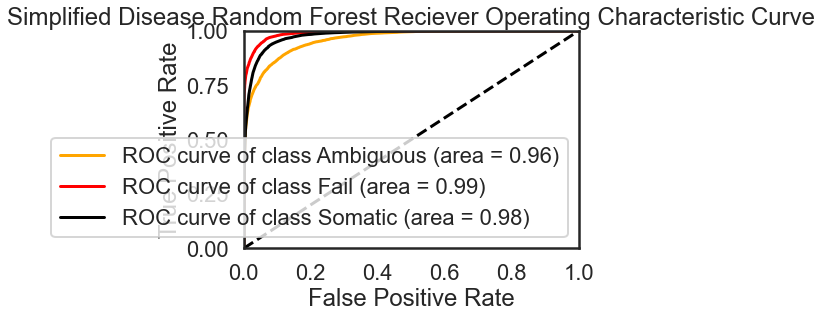

In [39]:
# Plot ROC curves 
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Simplified Disease '
                 'Random Forest Reciever Operating Characteristic Curve', ax)

confidence intervals +-:  [0.00062721 0.00322764 0.00587069 0.00789415 0.00924684 0.0099536
 0.0088385  0.00675162 0.00415921 0.00074367]


C:\Users\shubh\Documents\applied machine learning\DeepSVR\analysis_utils\ClassifierPlots.py:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([0, 1], [0, 1], 'k--', color='grey', linewidth=1)


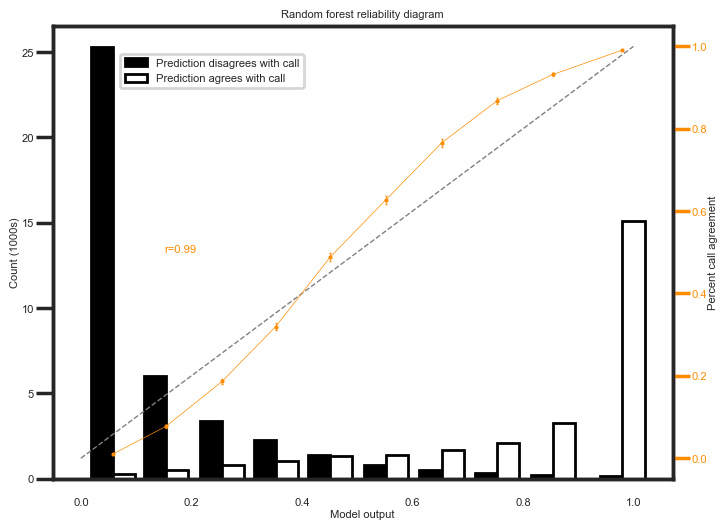

In [40]:
# Plot reliability diagram
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y_one_hot,['Ambiguous','Fail','Somatic'], 'darkorange', 'Random forest reliability diagram',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

### Test set performance

In [49]:
#Get probabilites for hold out test set
forest = estimator.fit(X_train, Y_train)
test_prob = forest.predict_proba(X_test)

In [50]:
# Add labels
Y_test_labels = enc.fit_transform(Y_test)

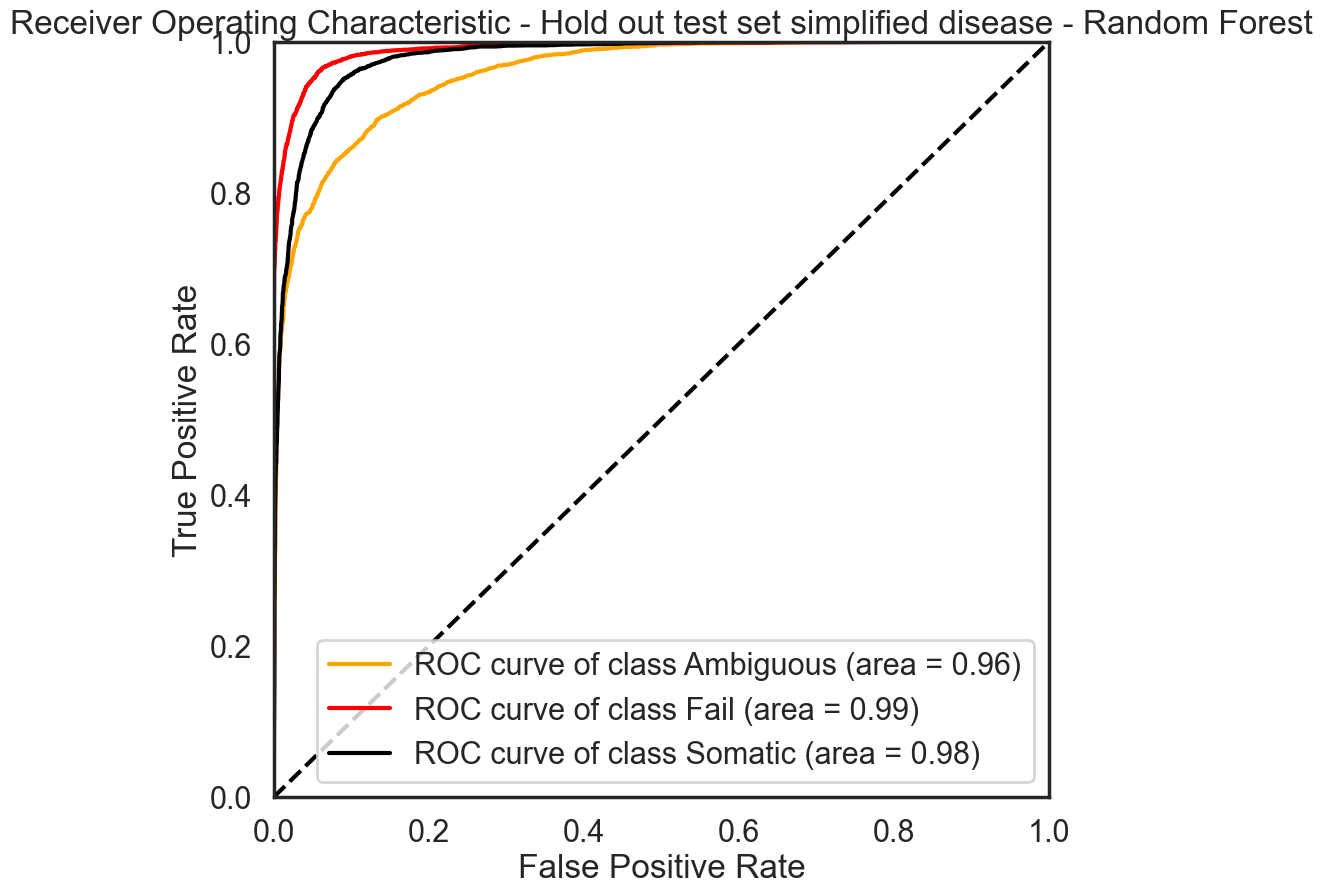

In [51]:
# PLot test set ROC

fig, ax = plt.subplots(figsize=(10,10),dpi=100)
create_roc_curve(Y_test_labels, test_prob, class_lookup, 'Receiver Operating '
                 'Characteristic - Hold out test set simplified disease - '
                 'Random Forest', ax)

confidence intervals +-:  [0.00089666 0.00452663 0.0081774  0.01140373 0.0135982  0.01396605
 0.01252582 0.00900526 0.00593249 0.00111901]


C:\Users\shubh\Documents\applied machine learning\DeepSVR\analysis_utils\ClassifierPlots.py:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([0, 1], [0, 1], 'k--', color='grey', linewidth=1)


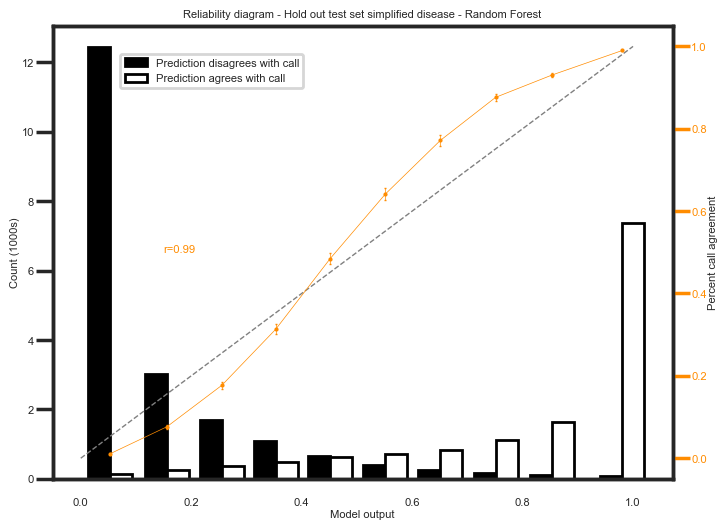

In [52]:
# Plot test set reliability diagram
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(test_prob, Y_test_labels,
                                 ['Ambiguous','Fail','Somatic'], 
                                 'darkorange', 'Reliability diagram - Hold out test set '
                                 'simplified disease - Random Forest',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

## Remove reviewer to simulate performance on de novo datasets

In [53]:
# Get Labels
Y = three_class.call.values
# Get training data as numpy array
s_v_b.sort_index(axis=1, inplace=True)
X = s_v_b.drop(['call', 'reviewer_1', 'reviewer_2', 'reviewer_3', 
                'reviewer_4'], axis=1).astype(float).values

In [54]:
# Test shape
X.shape

(41000, 59)

In [55]:
# Test shape
Y.shape

(41000,)

In [56]:
# Predict probabilites
probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [57]:
# Print accuracy profile
enc = preprocessing.MultiLabelBinarizer()
Y_one_hot = enc.fit_transform(Y)
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

Cross validation accuracy:
	 0.892

Cross validation classification report

              precision    recall  f1-score   support

           0       0.85      0.78      0.81     10643
           1       0.91      0.92      0.92     11976
           2       0.90      0.94      0.92     18381

   micro avg       0.89      0.89      0.89     41000
   macro avg       0.89      0.88      0.88     41000
weighted avg       0.89      0.89      0.89     41000
 samples avg       0.89      0.89      0.89     41000



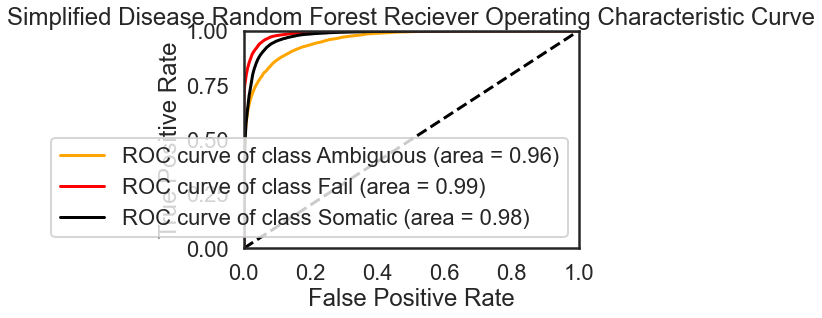

In [58]:
# Print ROC Curve for test set without reviewer
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Simplified Disease '
                 'Random Forest Reciever Operating Characteristic Curve', ax)

confidence intervals +-:  [0.00052056 0.00261911 0.00461605 0.00635168 0.00753262 0.00786583
 0.00681576 0.00514074 0.00339437 0.00061398]


C:\Users\shubh\Documents\applied machine learning\DeepSVR\analysis_utils\ClassifierPlots.py:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([0, 1], [0, 1], 'k--', color='grey', linewidth=1)


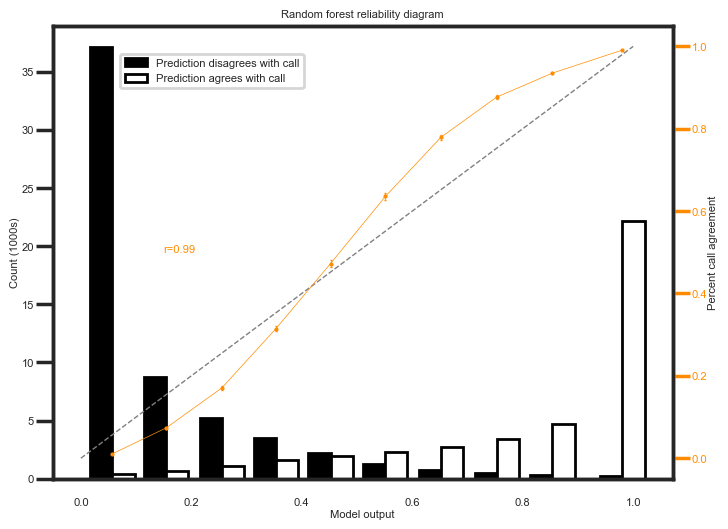

In [59]:
# Plot reliability diagram for test set without reviewer
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y_one_hot,['Ambiguous','Fail','Somatic'], 'darkorange', 'Random forest reliability diagram',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

In [60]:
# Format probabilities and store as xval_model_results
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [61]:
cv_somatic_error = get_somatic_error_type(Y_one_hot, predicted)

In [62]:
cv_somatic_error.index = training_data.index

In [63]:
probs_df = pd.DataFrame(probabilities, columns=['Ambiguous', 'Fail', 'Somatic'], index=training_data.index)

In [64]:
cv_somatic_error = pd.concat([cv_somatic_error, probs_df], axis=1)

In [65]:
print('remove')

remove


In [66]:
cv_somatic_error.to_pickle('data/random_forest/xval_model_results.pkl')

# Independent test analysis

In [67]:
# Get Labels
Y = three_class.call.values
# Get training data as numpy array
s_v_b.sort_index(axis=1, inplace=True)
X = s_v_b.drop(['call', 'reviewer_1', 'reviewer_2', 'reviewer_3', 
                'reviewer_4'], axis=1).astype(float).values

In [68]:
X.shape

(41000, 59)

In [69]:
Y.shape

(41000,)

In [70]:
forest = estimator.fit(X, Y)

In [71]:
# test oob score metrics
forest.oob_score_

0.8927317073170732

## SCLC

In [72]:
# Pull in manual review validation set (SCLC cases)
sclc_data = pd.read_pickle('data/independent_test/sclc_train.pkl')
# Label as solid tumor
sclc_data['solid_tumor'] = 1

In [73]:
# Pull in SCLC calls
sclc_call = pd.read_pickle('data/independent_test/sclc_call.pkl')
sclc_call=sclc_call.map(str.lower).replace('g','f').replace('s\x03', 's').replace('', 'f')
sclc_call.value_counts()

s    2526
f     145
a      15
Name: call, dtype: int64

In [74]:
# Get Labels
sclc_Y = sclc_call.values
# Get training data as numpy array
sclc_X = sclc_data.sort_index(axis=1).drop(['disease_SCLC', 'reviewer_Erica', 'reviewer_Lee'], axis=1).astype(float).values

In [75]:
# Employ RF model on SCLC data
sclc_probs = forest.predict_proba(sclc_X)

In [76]:
# Print accuracy profile
sclc_Y_one_hot = enc.fit_transform(sclc_Y)
print_accuracy_and_classification_report(sclc_Y_one_hot, predict_classes(sclc_probs))

Cross validation accuracy:
	 0.8112434847356664

Cross validation classification report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.11      0.14      0.12       145
           2       0.97      0.85      0.91      2526

   micro avg       0.81      0.81      0.81      2686
   macro avg       0.36      0.33      0.34      2686
weighted avg       0.92      0.81      0.86      2686
 samples avg       0.81      0.81      0.81      2686



In [77]:
# Save predictions
np.save('data/random_forest/sclc_y.npy', sclc_Y_one_hot)
np.save('data/random_forest/sclc_probs.npy', sclc_probs)

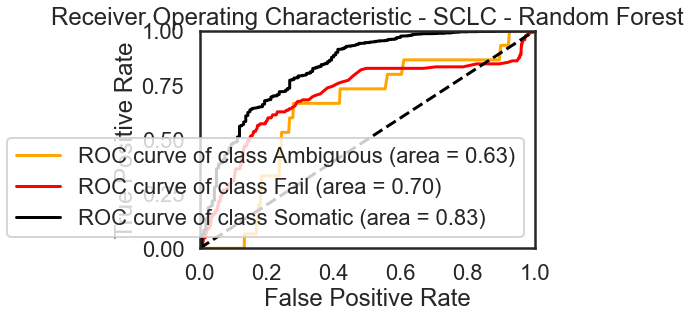

In [78]:
# Print AUC
fig, ax = plt.subplots()
create_roc_curve(sclc_Y_one_hot, sclc_probs, class_lookup, 'Receiver Operating '
                 'Characteristic - SCLC - Random Forest', ax)

## Access how much test data is need in training to rescue performance and compensate for batch effects

In [79]:
auc = []

for i in np.arange(0, 0.8, 0.05):
    if i == 0:
        sclc_X_test = sclc_X
        sclc_Y_test = sclc_Y
        X_train = X
        Y_train = Y
    else:
        (sclc_X_train, sclc_X_test, 
         sclc_Y_train, sclc_Y_test) = train_test_split(sclc_X, sclc_Y, 
                                                       train_size=i,
                                                       test_size=1-i,
                                                       random_state=seed, 
                                                       stratify=sclc_Y) 
        X_train = np.concatenate((X, sclc_X_train))
        Y_train = np.concatenate((Y, sclc_Y_train))
    print('Percentage of test data included in training: ', i*100)
    print('Training data shape: ', X_train.shape)
    print('Test data shape: ', sclc_X_test.shape)
    print('Number of test samples included in training: ', X_train.shape[0]-X.shape[0])
    forest = estimator.fit(X_train, Y_train)
    X_test_probs = forest.predict_proba(sclc_X_test)
    sclc_Y_test_one_hot = enc.fit_transform(sclc_Y_test)
    print_accuracy_and_classification_report(sclc_Y_test_one_hot, predict_classes(X_test_probs))
    temp_auc = []
    temp_auc.append(X_train.shape[0]-X.shape[0])
    Y_one_hot = enc.fit_transform(Y)
    for j in range(Y_one_hot.shape[1]):
        temp_auc.append(metrics.roc_auc_score(sclc_Y_test_one_hot[:, j], X_test_probs[:, j]))
    auc.append(temp_auc)
    print('Test AUC: ', temp_auc)
    print('---------------------------------------------------------')

Percentage of test data included in training:  0.0
Training data shape:  (41000, 59)
Test data shape:  (2686, 59)
Number of test samples included in training:  0
Cross validation accuracy:
	 0.810126582278481

Cross validation classification report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.10      0.14      0.12       145
           2       0.97      0.85      0.91      2526

   micro avg       0.81      0.81      0.81      2686
   macro avg       0.36      0.33      0.34      2686
weighted avg       0.92      0.81      0.86      2686
 samples avg       0.81      0.81      0.81      2686

Test AUC:  [0, 0.6332584550106077, 0.676128051676641, 0.8253476346001583]
---------------------------------------------------------
Percentage of test data included in training:  5.0
Training data shape:  (41134, 59)
Test data shape:  (2552, 59)
Number of test samples included in training:  134
Cross validation ac

Cross validation accuracy:
	 0.9635145197319435

Cross validation classification report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.94      0.45      0.61        73
           2       0.97      1.00      0.98      1263

   micro avg       0.96      0.96      0.96      1343
   macro avg       0.64      0.48      0.53      1343
weighted avg       0.96      0.96      0.96      1343
 samples avg       0.96      0.96      0.96      1343

Test AUC:  [1343, 0.8395530367835756, 0.9684715780390466, 0.9607927553444181]
---------------------------------------------------------
Percentage of test data included in training:  55.00000000000001
Training data shape:  (42477, 59)
Test data shape:  (1209, 59)
Number of test samples included in training:  1477
Cross validation accuracy:
	 0.9644334160463193

Cross validation classification report

              precision    recall  f1-score   support

           0     

C:\Users\shubh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross validation accuracy:
	 0.9627976190476191

Cross validation classification report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.94      0.44      0.60        36
           2       0.96      1.00      0.98       632

   micro avg       0.96      0.96      0.96       672
   macro avg       0.63      0.48      0.53       672
weighted avg       0.96      0.96      0.95       672
 samples avg       0.96      0.96      0.96       672

Test AUC:  [2014, 0.8214820359281436, 0.9651030747728861, 0.9478243670886075]
---------------------------------------------------------


C:\Users\shubh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


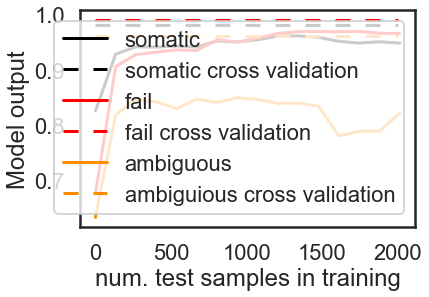

In [80]:
# Plot batch effects compensation
sclc_auc = pd.DataFrame(auc, columns=['num. test samples in training','ambiguous', 'fail','somatic'])
fig, ax = plt.subplots(1, 1)
sclc_auc.plot(x='num. test samples in training', y='somatic', ax=ax, color='black')
ax.plot([0, 2000], [.98,.98], linestyle='--', dashes=(5, 5),color='black', label='somatic cross validation')
sclc_auc.plot(x='num. test samples in training', y='fail', ax=ax, color='red')
ax.plot([0, 2000], [.99,.99], linestyle='--', dashes=(5, 5),color='red', label='fail cross validation')
sclc_auc.plot(x='num. test samples in training', y='ambiguous', ax=ax, color='darkorange')
ax.plot([0, 2000], [.96,.96], linestyle='--', dashes=(5, 5),color='darkorange', label='ambiguious cross validation')
ax.set_ylabel('Model output')
ax.legend()

In [81]:
# Save data to rf folder
sclc_auc.to_pickle('data/random_forest/sclc_batch_effect_correction.pkl')